In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import combinations

In [58]:
def load_gradients(base_path, file_name, num_epochs=8):
    """Load gradient data from JSON files for multiple epochs.

    Args:
    base_path (str): The directory path where the files are stored.
    file_name (str): The base name of the files without the epoch number.
    num_epochs (int): The number of epochs to load data for.

    Returns:
    dict: A dictionary containing gradient data for each epoch.
    """
    gradients = {}
    for epoch in range(1, num_epochs + 1):
        file_path = f"{base_path}/{file_name}/{file_name}_gradients_{epoch}.json"
        with open(file_path, 'r') as f:
            gradients[epoch] = json.load(f)
    return gradients

def aggregate_gradients(gradients, num_layers=3, num_modalities=2):
    """Aggregate gradients by per-modality routers across all epochs.

    Args:
        gradients (dict): Loaded gradient data.
        num_layers (int): Number of MoE layers.
        num_modalities (int): Number of modalities.

    Returns:
        dict: Aggregated gradient data organized by layer and modality.
    """
    aggregated_gradients = {layer: {modality: [] for modality in range(num_modalities)} for layer in range(num_layers)}

    # Loop over all epochs and accumulate gradient data for each modality in each layer
    for epoch_data in gradients.values():
        for layer in range(num_layers):
            for modality in range(num_modalities):
                key = f"trans_self_cross_ts_txt.layers.{layer}.moe.w_gate.{modality}"
                if key in epoch_data:
                    # Convert gradient data to numpy array for numerical operations
                    gradient_array = np.array(epoch_data[key])
                    aggregated_gradients[layer][modality].append(gradient_array)

    # Compute the mean of the accumulated gradients over epochs
    for layer in aggregated_gradients:
        for modality in aggregated_gradients[layer]:
            if aggregated_gradients[layer][modality]:  # Check if there are any gradients accumulated
                aggregated_gradients[layer][modality] = np.mean(aggregated_gradients[layer][modality], axis=0)

    return aggregated_gradients

# Two Modalities

In [8]:
def cosine_similarity(vec1, vec2):
    # Flatten the matrices into vectors
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    
    # Compute the dot product and norms
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Calculate cosine similarity
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0  # to handle cases where vectors are all-zeros
    return dot_product / (norm_vec1 * norm_vec2)


In [15]:
def compare_modalities(aggregated_gradients, num_layers, num_modalities):
    results = {}
    for layer in range(num_layers):
        results[layer] = {}
        for mod1 in range(num_modalities):
            for mod2 in range(mod1 + 1, num_modalities):
                key_pair = f"{mod1}-{mod2}"
                similarity = cosine_similarity(
                    aggregated_gradients[layer][mod1], 
                    aggregated_gradients[layer][mod2]
                )
                results[layer][key_pair] = similarity
    return results



## LOS

In [6]:
base_path = "/data/wang/junh/results/Fuse_moe/all_los/gradients"
TS_Text_gradients = load_gradients(base_path, "TS_Text")
TS_CXR_gradients = load_gradients(base_path, "TS_CXR")
TS_Text_aggregate = aggregate_gradients(TS_Text_gradients)
TS_CXR_aggregate = aggregate_gradients(TS_CXR_gradients)


In [50]:
TS_gradients = load_gradients(base_path, "TS")
TS_CXR_Text_gradients = load_gradients(base_path, "TS_CXR_Text")

In [ ]:
TS_CXR_Text_aggregate = aggregate_gradients(TS_CXR_Text_gradients, num_modalities=3)

In [24]:
print("TS_Text")
compare_modalities(TS_Text_aggregate, num_layers=3, num_modalities=2)


TS_Text


{0: {'0-1': -8.62161358145076e-05},
 1: {'0-1': 0.00880516700928926},
 2: {'0-1': 0.023061602561156615}}

In [25]:
print("TS_CXR")
compare_modalities(TS_CXR_aggregate, num_layers=3, num_modalities=2)

TS_CXR


{0: {'0-1': 0.03509473658441055},
 1: {'0-1': 0.044221346931338626},
 2: {'0-1': 0.023315106212138}}

In [34]:
print("TS_CXR_Text")
compare_modalities(TS_CXR_Text_aggregate, num_layers=3, num_modalities=3)

TS_CXR_Text


{0: {'0-1': -0.005331211831336596,
  '0-2': -0.002070066981770393,
  '1-2': 0.01731019948736071},
 1: {'0-1': -0.002872491978326589,
  '0-2': -0.0009541883002684952,
  '1-2': 0.005537425093885706},
 2: {'0-1': -0.006580422322703504,
  '0-2': -0.011615171221818715,
  '1-2': -0.001282860193645329}}

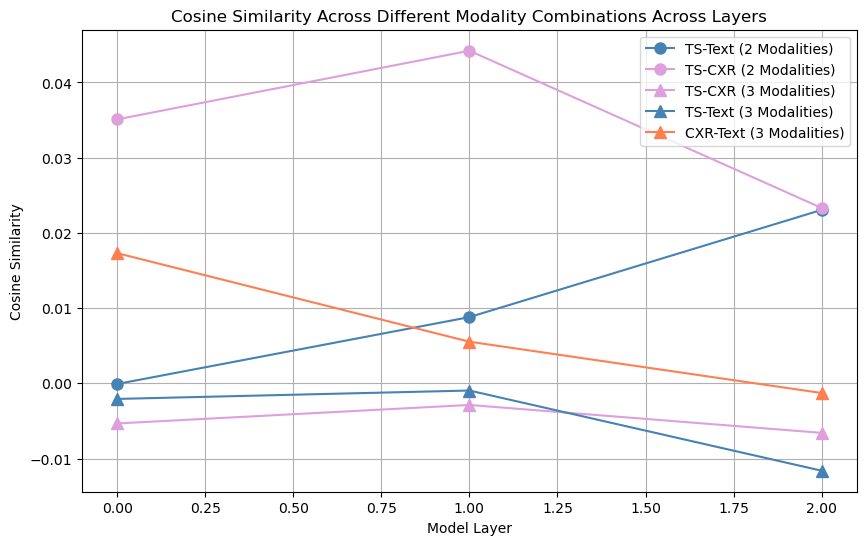

In [75]:
# Data Preparation
ts_text = {0: {'TS-Text': -8.62161358145076e-05},
           1: {'TS-Text': 0.00880516700928926},
           2: {'TS-Text': 0.023061602561156615}}

ts_cxr = {0: {'TS-CXR': 0.03509473658441055},
          1: {'TS-CXR': 0.044221346931338626},
          2: {'TS-CXR': 0.023315106212138}}

ts_cxr_text = {0: {'TS-CXR': -0.005331211831336596, 'TS-Text': -0.002070066981770393, 'CXR-Text': 0.01731019948736071},
               1: {'TS-CXR': -0.002872491978326589, 'TS-Text': -0.0009541883002684952, 'CXR-Text': 0.005537425093885706},
               2: {'TS-CXR': -0.006580422322703504, 'TS-Text': -0.011615171221818715, 'CXR-Text': -0.001282860193645329}}

# Extracting values from the data
layers = [0, 1, 2]
ts_text_vals = [ts_text[layer]['TS-Text'] for layer in layers]
ts_cxr_vals = [ts_cxr[layer]['TS-CXR'] for layer in layers]
ts_cxr_text_vals_ts_cxr = [ts_cxr_text[layer]['TS-CXR'] for layer in layers]
ts_cxr_text_vals_ts_text = [ts_cxr_text[layer]['TS-Text'] for layer in layers]
ts_cxr_text_vals_cxr_text = [ts_cxr_text[layer]['CXR-Text'] for layer in layers]

# Plotting with consistent color and different markers
plt.figure(figsize=(10, 6))
plt.plot(layers, ts_text_vals, 'o-', markersize=8, color='steelblue', label='TS-Text (2 Modalities)')
plt.plot(layers, ts_cxr_vals, 'o-', markersize=8, color='plum', label='TS-CXR (2 Modalities)')
plt.plot(layers, ts_cxr_text_vals_ts_cxr, '^-', markersize=8, color='plum', label='TS-CXR (3 Modalities)')
plt.plot(layers, ts_cxr_text_vals_ts_text, '^-', markersize=8, color='steelblue', label='TS-Text (3 Modalities)')
plt.plot(layers, ts_cxr_text_vals_cxr_text, '^-', markersize=8, color='coral', label='CXR-Text (3 Modalities)')

plt.xlabel('Model Layer')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Across Different Modality Combinations Across Layers')
plt.legend()
plt.grid(True)
plt.show()

# IHM

In [76]:
base_path = "/data/wang/junh/results/Fuse_moe/all_ihm/gradients"
TS_Text_gradients = load_gradients(base_path, "TS_Text")
TS_CXR_gradients = load_gradients(base_path, "TS_CXR")
TS_Text_aggregate = aggregate_gradients(TS_Text_gradients)
TS_CXR_aggregate = aggregate_gradients(TS_CXR_gradients)

In [77]:
TS_gradients = load_gradients(base_path, "TS")
TS_CXR_Text_gradients = load_gradients(base_path, "TS_CXR_Text")
TS_CXR_Text_aggregate = aggregate_gradients(TS_CXR_Text_gradients, num_modalities=3)

In [78]:
print("TS_Text")
compare_modalities(TS_Text_aggregate, num_layers=3, num_modalities=2)

TS_Text


{0: {'0-1': -0.002103327501261203},
 1: {'0-1': 0.005176585565207581},
 2: {'0-1': 0.0026084193993585786}}

In [79]:
print("TS_CXR")
compare_modalities(TS_CXR_aggregate, num_layers=3, num_modalities=2)

TS_CXR


{0: {'0-1': -0.0027453723390625183},
 1: {'0-1': 0.00015575962843784215},
 2: {'0-1': -0.0044886439704840365}}

In [80]:
print("TS_CXR_Text")
compare_modalities(TS_CXR_Text_aggregate, num_layers=3, num_modalities=3)

TS_CXR_Text


{0: {'0-1': 0.011363511489996437,
  '0-2': 0.009820574944453028,
  '1-2': 0.001974789249164168},
 1: {'0-1': -0.008265926447024726,
  '0-2': 0.0037230715063772788,
  '1-2': -0.010615443032741772},
 2: {'0-1': -0.008912667329523666,
  '0-2': -0.002739551489605524,
  '1-2': 0.022018889485829727}}

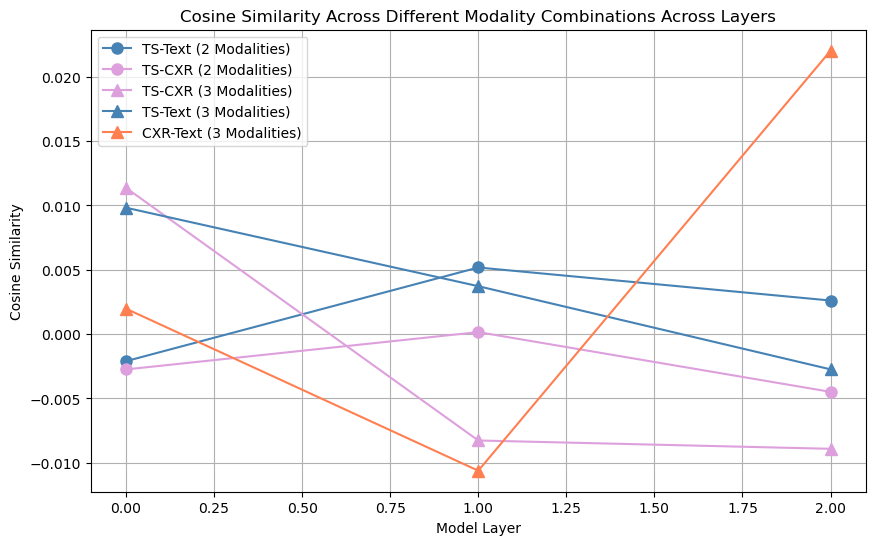

In [81]:
# Data Preparation
ts_text = {0: {'TS-Text': -0.00210332750126120},
           1: {'TS-Text': 0.005176585565207581},
           2: {'TS-Text': 0.0026084193993585786}}

ts_cxr = {0: {'TS-CXR': -0.0027453723390625183},
          1: {'TS-CXR': 0.00015575962843784215},
          2: {'TS-CXR': -0.0044886439704840365}}

ts_cxr_text = {0: {'TS-CXR': 0.011363511489996437, 'TS-Text': 0.009820574944453028, 'CXR-Text': 0.001974789249164168},
               1: {'TS-CXR': -0.008265926447024726, 'TS-Text': 0.0037230715063772788, 'CXR-Text': -0.010615443032741772},
               2: {'TS-CXR': -0.008912667329523666, 'TS-Text': -0.002739551489605524, 'CXR-Text': 0.022018889485829727}}

# Extracting values from the data
layers = [0, 1, 2]
ts_text_vals = [ts_text[layer]['TS-Text'] for layer in layers]
ts_cxr_vals = [ts_cxr[layer]['TS-CXR'] for layer in layers]
ts_cxr_text_vals_ts_cxr = [ts_cxr_text[layer]['TS-CXR'] for layer in layers]
ts_cxr_text_vals_ts_text = [ts_cxr_text[layer]['TS-Text'] for layer in layers]
ts_cxr_text_vals_cxr_text = [ts_cxr_text[layer]['CXR-Text'] for layer in layers]

# Plotting with consistent color and different markers
plt.figure(figsize=(10, 6))
plt.plot(layers, ts_text_vals, 'o-', markersize=8, color='steelblue', label='TS-Text (2 Modalities)')
plt.plot(layers, ts_cxr_vals, 'o-', markersize=8, color='plum', label='TS-CXR (2 Modalities)')
plt.plot(layers, ts_cxr_text_vals_ts_cxr, '^-', markersize=8, color='plum', label='TS-CXR (3 Modalities)')
plt.plot(layers, ts_cxr_text_vals_ts_text, '^-', markersize=8, color='steelblue', label='TS-Text (3 Modalities)')
plt.plot(layers, ts_cxr_text_vals_cxr_text, '^-', markersize=8, color='coral', label='CXR-Text (3 Modalities)')

plt.xlabel('Model Layer')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Across Different Modality Combinations Across Layers')
plt.legend()
plt.grid(True)
plt.show()